In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Loading train set from: ./jhu_crowd_v2.0/train
train batch shape: torch.Size([32, 1, 256, 256])
train crowd counts: tensor([243., 686.,  96., 185., 155., 222., 119.,  39., 141.,  33., 129., 183.,
         49.,  19., 277.,  37., 173., 289., 173.,  87.,  63., 200.,  63., 356.,
         33., 231.,  24.,  45., 227., 391., 994., 106.])

Loading val set from: ./jhu_crowd_v2.0/val
val batch shape: torch.Size([32, 1, 256, 256])
val crowd counts: tensor([804.,  41.,  26.,  31.,  40.,  35.,  96.,  32., 140., 210.,  90., 133.,
        144., 408.,  60.,  20.,  39., 498., 134., 236., 281.,  14., 166., 142.,
        168.,  17., 662.,  68.,  18., 102., 183.,  50.])

Loading test set from: ./jhu_crowd_v2.0/test
test batch shape: torch.Size([32, 1, 256, 256])
test crowd counts: tensor([ 43.,  59., 463., 299., 140.,  28.,  45.,  33.,  50.,  55., 284., 275.,
         52., 212., 134., 270., 200.,  70.,   4., 172.,   2.,  98.,  38.,  54.,
         27., 129., 187.,   0., 184.,  43.,  53., 548.])


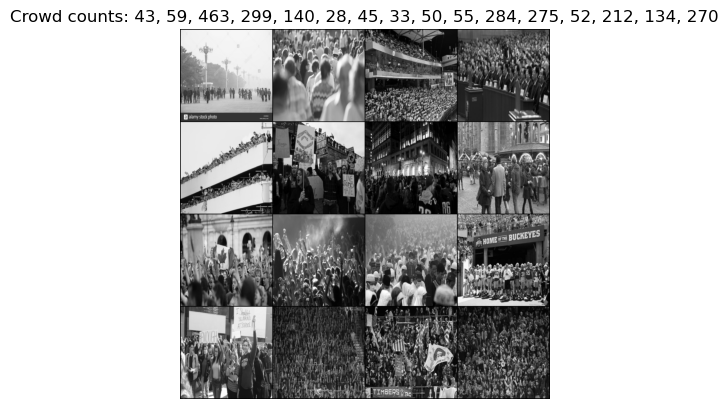


Loading train set from: ./jhu_crowd_v2.0/train
train batch shape: torch.Size([32, 1, 256, 256])
train crowd counts: tensor([ 59.,  12.,  57., 101., 128.,  11.,  41.,  16.,  15., 161., 266.,  16.,
        254.,  45., 180., 329., 778., 183.,  35.,  83., 378., 317., 293.,  19.,
         82., 146.,  29., 476., 498., 578.,  13.,  83.])

Loading val set from: ./jhu_crowd_v2.0/val
val batch shape: torch.Size([32, 1, 256, 256])
val crowd counts: tensor([804.,  41.,  26.,  31.,  40.,  35.,  96.,  32., 140., 210.,  90., 133.,
        144., 408.,  60.,  20.,  39., 498., 134., 236., 281.,  14., 166., 142.,
        168.,  17., 662.,  68.,  18., 102., 183.,  50.])

Loading test set from: ./jhu_crowd_v2.0/test
test batch shape: torch.Size([32, 1, 256, 256])
test crowd counts: tensor([ 43.,  59., 463., 299., 140.,  28.,  45.,  33.,  50.,  55., 284., 275.,
         52., 212., 134., 270., 200.,  70.,   4., 172.,   2.,  98.,  38.,  54.,
         27., 129., 187.,   0., 184.,  43.,  53., 548.])
All crowd 

In [2]:
# Pre Processing

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images_dir = os.path.join(data_dir, 'images')
        self.label_path = os.path.join(data_dir, 'image_labels.txt')
        self.transform = transform

        self.samples = []
        with open(self.label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 2:
                    image_id = parts[0]
                    count = float(parts[1])
                    if count > 1000:
                        continue  # skip this image
                    filename = image_id + '.jpg'
                    self.samples.append((filename, count))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, count = self.samples[idx]
        image_path = os.path.join(self.images_dir, filename)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        count = torch.tensor(count, dtype=torch.float32)

        return image, count

# Shared preprocessing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define paths to each data split
base_dir = './jhu_crowd_v2.0'
splits = {
    'train': os.path.join(base_dir, 'train'),
    'val': os.path.join(base_dir, 'val'),
    'test': os.path.join(base_dir, 'test')
}

# Load and preview each split
if __name__ == '__main__':
    for split_name, path in splits.items():
        print(f"\nLoading {split_name} set from: {path}")
        dataset = CrowdDataset(data_dir=path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=(split_name == 'train'))

        for images, counts in dataloader:
            print(f"{split_name} batch shape:", images.shape)
            print(f"{split_name} crowd counts:", counts)
            break


# JUST TO VISUALIZE THAT ITS WORKING:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# Show first N samples in a grid
N = 16
images = []
labels = []

for i in range(N):
    img, count = dataset[i]
    img = img * 0.5 + 0.5  # unnormalize
    images.append(img)
    labels.append(f"{int(count.item())}")

# Combine into a single grid
grid = make_grid(torch.stack(images), nrow=4, padding=2)
np_grid = TF.to_pil_image(grid)

plt.imshow(np_grid, cmap='gray')
plt.axis('off')
plt.title("Crowd counts: " + ", ".join(labels))
plt.show()


def export_tensor_dataset(dataset, output_path='tensor_dataset.pt'):
    data = []
    for img, count in dataset:
        data.append((img, torch.tensor(count)))  # convert count to tensor for consistency

    torch.save(data, output_path)

if __name__ == '__main__':
    all_counts = []

    for split_name, path in splits.items():
        print(f"\nLoading {split_name} set from: {path}")
        dataset = CrowdDataset(data_dir=path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=(split_name == 'train'))

        for images, counts in dataloader:
            print(f"{split_name} batch shape:", images.shape)
            print(f"{split_name} crowd counts:", counts)
            all_counts.extend(counts.tolist())  # Collect counts

            break

    print("All crowd counts (comma-separated):")
    print(','.join(str(int(count)) for count in all_counts))

In [3]:
#Model Definition

import torchvision.models as models
import torch.nn as nn

class ResNetCrowdRegressor(nn.Module):
    def __init__(self):
        super(ResNetCrowdRegressor, self).__init__()
        from torchvision.models import resnet18, ResNet18_Weights
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # If using grayscale images, change first conv layer
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(*list(resnet.children())[:-3])  # remove avgpool + FC

        # Freeze pretrained layers
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1)
    )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x.squeeze(1)



In [4]:
import torch.nn as nn

class LogMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        eps = 1e-6  # small value to avoid log(0)
        log_pred = torch.log(prediction + eps)
        log_target = torch.log(target + eps)
        return nn.functional.mse_loss(log_pred, log_target)

In [5]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    loop = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())
    
    return total_loss / len(dataloader.dataset)


In [6]:
# Training loop

# Load datasets
train_dataset = CrowdDataset(splits['train'], transform=transform)
val_dataset = CrowdDataset(splits['val'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   # for faster epochs, assuming GPU allows; change back to 16 if memory error
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model, loss, optimizer
model = ResNetCrowdRegressor().to(device)
criterion = torch.nn.L1Loss()  #  MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6
)

# Training loop
num_epochs = 15
best_val_loss = float('inf')
patience = 3
min_delta = 0.001
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_model(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
            }, 'best_model.pt')
    else:
        patience_counter += 1

    scheduler.step(val_loss)

    if patience_counter >= patience:
        print("Early stopping.")
        break


Epoch 1/15


Train Loss: 166.7372 | Val Loss: 153.5798

Epoch 2/15


Train Loss: 160.2144 | Val Loss: 141.5321

Epoch 3/15


Train Loss: 144.0595 | Val Loss: 126.1167

Epoch 4/15


Train Loss: 130.2488 | Val Loss: 120.6451

Epoch 5/15


Train Loss: 126.6954 | Val Loss: 120.1955

Epoch 6/15


Train Loss: 125.4787 | Val Loss: 120.0874

Epoch 7/15


Train Loss: 124.9381 | Val Loss: 119.7493

Epoch 8/15


Train Loss: 124.4517 | Val Loss: 119.3616

Epoch 9/15


Train Loss: 124.5200 | Val Loss: 118.9061

Epoch 10/15


Train Loss: 123.7469 | Val Loss: 118.5017

Epoch 11/15


Train Loss: 123.4130 | Val Loss: 118.0249

Epoch 12/15


Train Loss: 122.5811 | Val Loss: 117.5467

Epoch 13/15


Train Loss: 122.2584 | Val Loss: 116.8463

Epoch 14/15


Train Loss: 121.2350 | Val Loss: 116.2708

Epoch 15/15


Train Loss: 121.0625 | Val Loss: 115.6845


In [7]:
test_dataset = CrowdDataset(splits['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Test MAE: {test_loss:.4f}")

Test MSE: 129.9746


In [8]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
            }, 'final_model.pt')
print("Saved final model weights to 'final_model.pt'.")

Saved final model weights to 'final_model.pt'.


In [9]:
from PIL import Image
import torch

def predict_count_from_image(model, image_path, transform, device='cpu'):
    """
    Predict the crowd count for a single image.
    
    Args:
        model: Trained CNN model.
        image_path (str): Path to the image file.
        transform: The preprocessing transform used during training.
        device: 'cuda' or 'cpu'.
    
    Returns:
        float: Predicted crowd count.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        prediction = model(image)
        predicted_count = prediction.item()

    return predicted_count

In [11]:
test_image_path = "./jhu_crowd_v2.0/test.jpg"  # or any path
predicted = predict_count_from_image(model, test_image_path, transform, device)
print(f"Predicted Crowd Count: {predicted:.2f}")

Predicted Crowd Count: 89.67


In [14]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

# Define the model class exactly as in training
class ResNetCrowdRegressor(nn.Module):
    def __init__(self):
        super(ResNetCrowdRegressor, self).__init__()
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Adjust for grayscale images
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-3])  # remove avgpool + FC
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x.squeeze(1)
    

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetCrowdRegressor().to(device)
criterion = torch.nn.L1Loss()  #  MAE
# model.load_state_dict(torch.load('best_model.pt', map_location=device))
checkpoint = torch.load('best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define the same transform (for a single grayscale image)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel
    transforms.Resize((224, 224)),  # Match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you normalized around 0.5
])

# Load an image for inference
img_path = 'jhu_crowd_v2.0/test.jpg'  # Replace with your image path
image = Image.open(img_path).convert('RGB')  # Your image might be RGB, so convert properly
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_count = output.item()

print(f'Predicted Count: {predicted_count:.2f}')

# Interpret the result
if predicted_count < 10:
    print("Status: Empty")
elif predicted_count < 20:
    print("Status: A few people")
elif predicted_count < 40:
    print("Status: Average crowd")
elif predicted_count < 60:
    print("Status: Getting busy")
elif predicted_count < 80:
    print("Status: Busy")
else:
    print("Status: Packed")

Predicted Count: 93.27
Status: Packed
